In [1]:
from watchdog.observers.kqueue import absolute_path

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

In [2]:
import sys
if IN_COLAB:
    !git clone -q https://github.com/lukaslaobeyer/token-opt.git
    !pip install -q --progress-bar off jaxtyping open_clip_torch omegaconf
    sys.path.insert(0, "token-opt")
else:
    sys.path.insert(0, "..")

In [3]:
import os
# Set this environment for deterministic execution
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

In [4]:
import torch
# Enable for deterministic algorithms
torch.use_deterministic_algorithms(True, warn_only=False)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from pathlib import Path
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as v2
import torchvision.transforms.v2.functional as tvf
from torchvision.datasets import ImageNet
from einops import rearrange

In [5]:
from tto.test_time_opt import (
    TestTimeOpt,
    TestTimeOptConfig,
    CLIPObjective,
)

In [6]:
device = torch.device("cuda")

## Utils

In [7]:
def load_img(path, device=None):
    p = Path(path)
    if IN_COLAB and not p.is_absolute():
        # assume la cartella caricata in Colab è /content/image_test
        p = Path("/content") / Path("image_test") / p

    if not p.exists():
        raise FileNotFoundError(f"Image not found: {p}")

    pil_img = Image.open(p).convert("RGB")
    tensor = (1.0 / 255.0) * torch.from_numpy(
        np.array(pil_img).astype(np.float32)
    ).permute(2, 0, 1)
    tensor = tvf.resize(tensor, 256)
    tensor = tvf.center_crop(tensor, 256)
    tensor = tensor.unsqueeze(0)
    if device is not None:
        tensor = tensor.to(device)
    return tensor

def display_image(*tensors):
    tensors = [255. * t.squeeze() for t in tensors]
    img = Image.fromarray(rearrange(
        tensors, "b c h w -> h (b w) c"
    ).to("cpu", dtype=torch.uint8).numpy())
    display(img)

def opt_callback(info):
    if info.i % 50 == 0:
        print(f"i = {info.i}")
        print("  CLIP score =", "\t".join(
            map(lambda l: f"{-l:.3f}", info.loss))
        )
        imgs = tto.decode(info.tokens).clamp(0., 1.)
        display_image(*imgs)

# Set up the objective function

In [ ]:
# Use CLIP similarity maximization objective
objective = CLIPObjective(num_augmentations=8, cfg_scale=1.2)

# Set prompt
objective.prompt = [
    "a photo of a tiger",
    "a photo of a husky",
    "a photo of a sparrow",
]

# Optionally set a negative prompt
# Note: also need to set cfg_scale > 1 in CLIPObjective if using this!
objective.neg_prompt = "bad, low-res, unnatural"

# Configure test time optimization

In [9]:
tto_config = TestTimeOptConfig(
    num_iter=301,
    ema_decay=0.98,
    lr=1e-1,
    enable_amp=True,
    reg_weight=0.025,
    #token_noise=1e-3,
    reg_type="seed",
)
tto = TestTimeOpt(tto_config, objective).to(device)

# Load seed images

In [10]:
# Load seed image
img = torch.cat([
    load_img("ILSVRC2012_val_00008636.png", device),
    load_img("ILSVRC2012_val_00008636.png", device),
    load_img("ILSVRC2012_val_00010240.png", device),
], dim=0)

# Alternatively, initialize directly from given tokens (e.g. randomly
# sampled), but this is disabled when setting `seed_tokens = None`.
seed_tokens = None

# Run Optimization

Seed


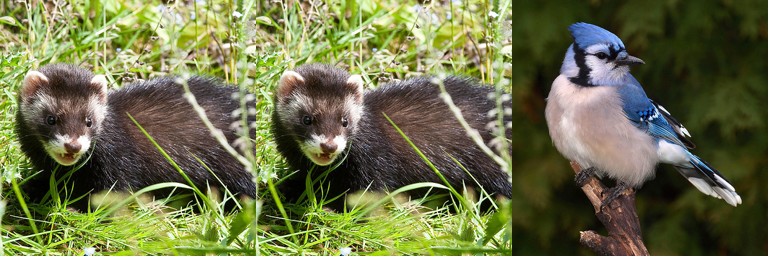

i = 0
  CLIP score = 0.080	0.108	0.221


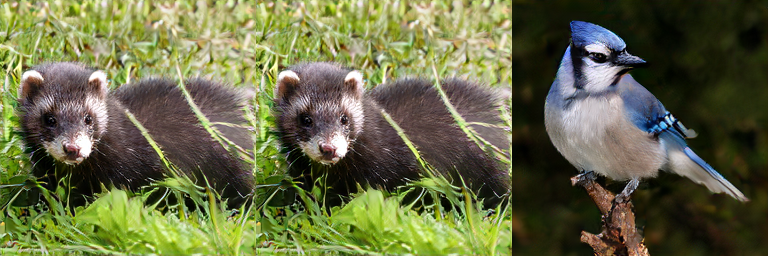

i = 50
  CLIP score = 0.231	0.299	0.306


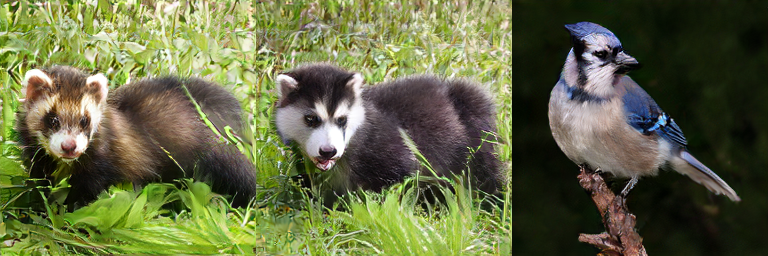

i = 100
  CLIP score = 0.271	0.313	0.335


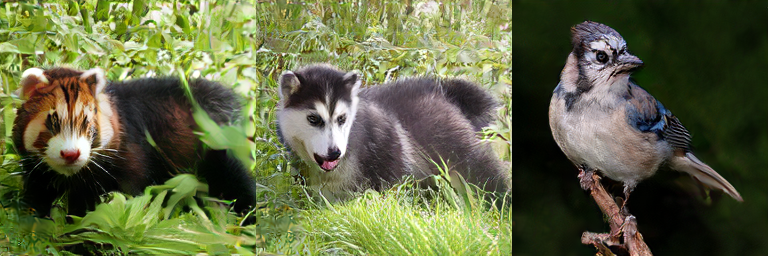

i = 150
  CLIP score = 0.281	0.322	0.340


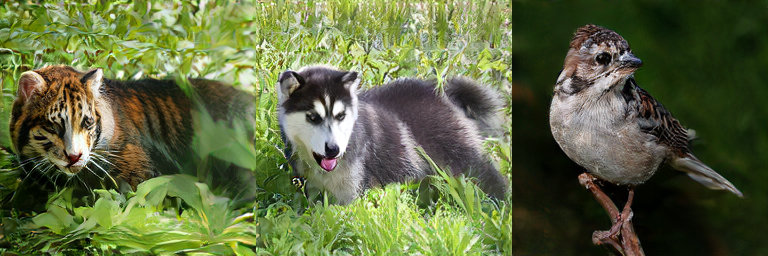

i = 200
  CLIP score = 0.281	0.316	0.335


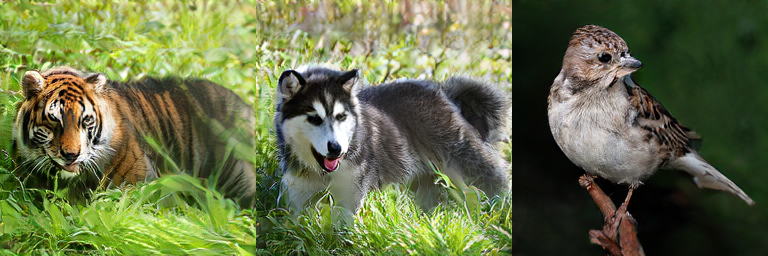

i = 250
  CLIP score = 0.291	0.327	0.346


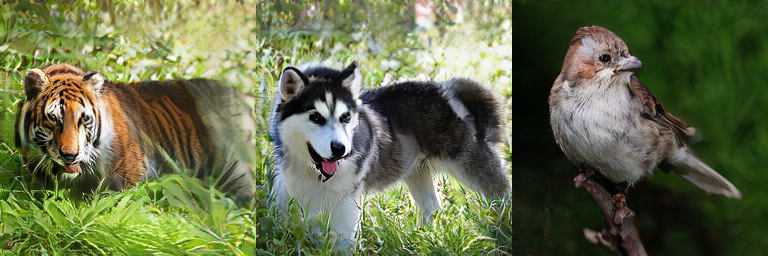

i = 300
  CLIP score = 0.297	0.324	0.334


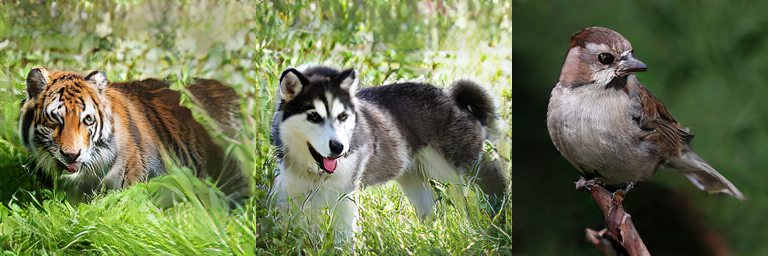

In [11]:
print("Seed")
display_image(*img)

# Run optimization
torch.manual_seed(0)
img_opt = tto(
    seed=img if seed_tokens is None else None,
    seed_tokens=seed_tokens,
    callback=opt_callback
)